In [1]:
# To use the files in the parent directory run this cell
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# from src.models.vqvae import VQVAE
from src.models.full_vqvae import VQVAE
from src.models.modified_var import VAR
from src.datasets.hugging_face_dataset import HuggingFaceDataset

# Setup original VAR paper VQVAE

In [3]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import gc
from tqdm import tqdm

from torch import nn

In [4]:

def build_vae(
    # Shared args
    device, patch_nums=(1, 2, 3, 4, 5, 6, 8, 10, 13, 16),   # 10 steps by default
    # VQVAE args
    V=4096, Cvae=32, ch=160, share_quant_resi=4,
) -> VQVAE:
    # disable built-in initialization for speed
    # for clz in (nn.Linear, nn.LayerNorm, nn.BatchNorm2d, nn.SyncBatchNorm, nn.Conv1d, nn.Conv2d, nn.ConvTranspose1d, nn.ConvTranspose2d):
    #     setattr(clz, 'reset_parameters', lambda self: None)
    
    # build models
    vae_local = VQVAE(vocab_size=V, z_channels=Cvae, ch=ch, test_mode=True, share_quant_resi=share_quant_resi, v_patch_nums=patch_nums).to(device)
    
    return vae_local

In [5]:
################## 1. Download checkpoints and build models
import os
import os.path as osp
import random
import PIL.Image as PImage, PIL.ImageDraw as PImageDraw
# setattr(torch.nn.Linear, 'reset_parameters', lambda self: Nojne)     # disable default parameter init for faster speed
# setattr(torch.nn.LayerNorm, 'reset_parameters', lambda self: None)  # disable default parameter init for faster speed

MODEL_DEPTH = 16    # TODO: =====> please specify MODEL_DEPTH <=====
assert MODEL_DEPTH in {16, 20, 24, 30}


# download checkpoint
hf_home = 'https://huggingface.co/FoundationVision/var/resolve/main'
vae_ckpt= 'vae_ch160v4096z32.pth'
if not osp.exists(vae_ckpt): os.system(f'wget {hf_home}/{vae_ckpt}')

# build vae, var
patch_nums = (1, 2, 3, 4, 5, 6, 8, 10, 13, 16)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
if 'vae' not in globals() or 'var' not in globals():
    vae = build_vae(
        V=4096, Cvae=32, ch=160, share_quant_resi=4,    # hard-coded VQVAE hyperparameters
        device=device, patch_nums=patch_nums,
    )

# load checkpoints
vae.load_state_dict(torch.load(vae_ckpt, map_location='cpu'), strict=True)
for p in vae.parameters(): p.requires_grad_(False)
print(f'prepare finished.')

Using device: cuda
prepare finished.


/tmp/ipykernel_46953/142678758.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(vae_ckpt, map_location='cpu'), strict=True)


# Parameters and Datset

In [7]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import gc
from tqdm import tqdm


model_params = {
    "mnist": {
        "VQVAE_DIM": 64,
        "VOCAB_SIZE": 32,
        "PATCH_SIZES": [1, 2, 3, 4, 8],
        "VAR_DIM": 64,
        "N_HEADS": 4,
        "N_LAYERS": 6,
        "channels": 1,
    },
    "cifar": {
        "VQVAE_DIM": 512,
        "VOCAB_SIZE": 2048,
        "PATCH_SIZES": [1, 2, 3, 4, 6, 8],
        "VAR_DIM": 512,
        "N_HEADS": 16,
        "N_LAYERS": 12,
        "channels": 3,
    },
    "small": {
        "VQVAE_DIM": 128,
        "VOCAB_SIZE": 4096,
        "PATCH_SIZES": [1, 2, 3, 4, 6, 8],
        "VAR_DIM": 512,
        "N_HEADS": 16,
        "N_LAYERS": 16,
        "channels": 3,
    },
    # "medium": {
    #     "VQVAE_DIM": 512,
    #     "VOCAB_SIZE": 2048,
    #     "PATCH_SIZES": [1, 2, 3, 4, 6, 8],
    #     "VAR_DIM": 512,
    #     "N_HEADS": 32,
    #     "N_LAYERS": 20,
    #     "channels": 3,
    # },
    # "large": {
    #     "VQVAE_DIM": 512,
    #     "VOCAB_SIZE": 4096,
    #     "PATCH_SIZES": [1, 2, 3, 4, 6, 8],
    #     "VAR_DIM": 512,
    #     "N_HEADS": 64,
    #     "N_LAYERS": 24,
    #     "channels": 3,
    # },
}

training_params = {
    "mnist": {
        "VQVAE": {
            "batch_size": 2048,
            "lr": 3e-4,
            "epochs": 40,
        },
        "VAR": {
            "batch_size": 1024,
            "lr": 1e-3,
            "epochs": 100,
        },
    },
    "cifar": {
        "VQVAE": {
            "batch_size": 128,
            "lr": 1e-4,
            "epochs": 100,
        },
        "VAR": {
            "batch_size": 128,
            "lr": 1e-4,
            "epochs": 100,
        },
    },
}


def get_data(batch_size=1024, dataset="mnist"):
    if dataset == "cifar":
        transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.RandomCrop(32),
                transforms.RandomHorizontalFlip(),
                transforms.Normalize((0.5,), (0.5,)),
            ]
        )
        train_ds = datasets.CIFAR10(
            root="./data", train=True, download=True, transform=transform
        )
        test_ds = datasets.CIFAR10(
            root="./data", train=False, download=True, transform=transform
        )
    elif dataset == "mnist":
        transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Pad(2),
                transforms.Normalize((0.5,), (0.5,)),
            ]
        )
        train_ds = datasets.MNIST(
            root="./data", train=True, download=True, transform=transform
        )
        test_ds = datasets.MNIST(
            root="./data", train=False, download=True, transform=transform
        )
    else:
        transform = transforms.Compose(
            [
                transforms.ToTensor(),
                # transforms.Resize((32, 32)),
                transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BICUBIC),
                transforms.Normalize((0.5,), (0.5,)),
            ]
        )
        # Use HuggingFace datasets
        train_ds = HuggingFaceDataset(dataset_path=dataset, split="train", transform=transform)
        test_ds = HuggingFaceDataset(dataset_path=dataset, split="val", transform=transform)


    train_loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=False, drop_last=False
    )
    test_loader = DataLoader(
        test_ds, batch_size=batch_size, shuffle=False, drop_last=True
    )

    print(len(train_loader), len(test_loader))

    return train_loader, test_loader


def plot_images(pred, original=None, save=False, id=0):
    n = pred.size(0)
    pred = pred * 0.5 + 0.5
    pred = pred.clamp(0, 1)
    img = pred.cpu().detach()

    if original is not None:
        original = original * 0.5 + 0.5
        original = original.clamp(0, 1)
        original = original.cpu().detach()
        img = torch.cat([original, img], dim=0)

    img_grid = make_grid(img, nrow=n)
    img_grid = img_grid.permute(1, 2, 0).numpy()
    img_grid = (img_grid * 255).astype("uint8")
    plt.imshow(img_grid)
    plt.axis("off")
    if save:
        plt.savefig(f"var_{id}.png")
    plt.show()
    plt.close()


# Example of original VAR paper VQVAE usage

14630 1500
Using device: cuda


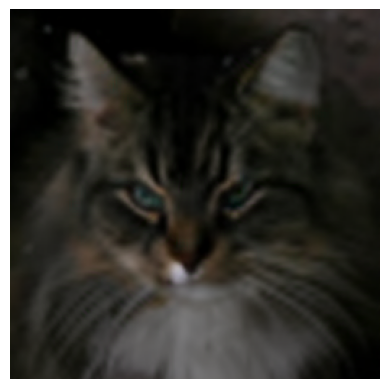

In [8]:
# Use VQVAE to encode and decode images
dataset = "zzsi/afhq64_16k"
train_loader, test_loader = get_data(batch_size=1, dataset=dataset)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Get a batch of images
images, _ = next(iter(train_loader))

# images are 32x32x3, but we need them to be 512x512x3
# images = F.interpolate(images, size=(256, 256), mode="bicubic", align_corners=False)

images = images.to(device)

# image = vae.img_to_reconstructed_img(images)

image = vae.img_to_idxBl(images)

image = vae.idxBl_to_img(image, same_shape=True)

plot_images(image[-1], save=False)


In [9]:
with torch.no_grad():
    torch.cuda.empty_cache()

# Training VAR using original VQVAE

==========Training VAR==========
VQVAE Parameters: 108.95M
VAR Parameters: 118.72M
915 93
Epoch: 0, Loss: 8.081813824763064


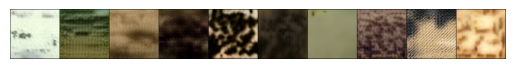

Epoch: 1, Loss: 8.020697836016046


KeyboardInterrupt: 

In [11]:
print("=" * 10 + "Training VAR" + "=" * 10)
vqvae = vae
# vqvae = VQVAE(
#     model_params["VQVAE_DIM"],
#     model_params["VOCAB_SIZE"],
#     model_params["PATCH_SIZES"],
#     num_channels=model_params["channels"],
# )
# vqvae.load_state_dict(torch.load("vqvae.pth"))  # LOADS the trained VQVAE model
# vqvae = vqvae.to("cuda")
vqvae.eval()

for param in vqvae.parameters():
    param.requires_grad = False

var_model = VAR(
    vqvae=vqvae,
    dim=160,
    n_heads=16,
    n_layers=16,
    patch_sizes=[1, 2, 3, 4, 5, 6, 8, 10, 13, 16],
    n_classes=10,
)
optimizer = torch.optim.AdamW(
    var_model.parameters(), lr=1e-4
)

quantize_local = vqvae.quantize

print(f"VQVAE Parameters: {sum(p.numel() for p in vqvae.parameters())/1e6:.2f}M")
print(f"VAR Parameters: {sum(p.numel() for p in var_model.parameters())/1e6:.2f}M")

train_loader, test_loader = get_data(
    batch_size=16, dataset=dataset
)
var_model = var_model.to("cuda")

for epoch in range(100):
    epoch_loss = 0
    for i, (x, c) in enumerate(train_loader):
        x, c = x.cuda(), c.cuda()
        optimizer.zero_grad()

        gt_idx_Bl = vqvae.img_to_idxBl(x)
        idx_BL = torch.cat(gt_idx_Bl, dim=1)
        x_BLCv_wo_first_l = quantize_local.idxBl_to_var_input(gt_idx_Bl)
        # print(f"x_BLCv_wo_first_l stats: {x_BLCv_wo_first_l.min().item()}, {x_BLCv_wo_first_l.mean().item()}, {x_BLCv_wo_first_l.max().item()}")
        logits_BLV = var_model(x_BLCv_wo_first_l, cond=c)
        # print(f"logits_BLV stats: {logits_BLV.min().item()}, {logits_BLV.mean().item()}, {logits_BLV.max().item()}")
        loss = F.cross_entropy(
            logits_BLV.view(-1, logits_BLV.size(-1)), idx_BL.view(-1)
        )

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    print(f"Epoch: {epoch}, Loss: {epoch_loss}")

    if epoch % 5 == 0:
        with torch.no_grad():

            cond = torch.arange(10).cuda()
            out_B3HW = var_model.generate(cond, 0)
            plot_images(pred=out_B3HW, save=True, id=epoch)

torch.save(var_model.state_dict(), "var.pth")